In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from xgboost import XGBClassifier as XGBC
import plotly.express as px
from umap import UMAP
from sklearn.manifold import TSNE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from IPython.display import Image, display
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from scipy.stats import norm

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
static_train = pd.read_csv('one-hot-encoded/static_train.csv')
static_val = pd.read_csv('one-hot-encoded/static_val.csv')


In [3]:
static_test = pd.read_csv('one-hot-encoded/static_test.csv')
static_test=static_test.sort_values(by=['id'])
static_test= static_test.reset_index(drop=True)

In [4]:
static_train=static_train.sort_values(by=['id'])
static_train= static_train.reset_index(drop=True)
static_train

,id,hosp_admittime,hosp_dischtime,icu_intime,icu_outtime,los_icu,icu_death,gender,race,admission_age,...,ckd,cld,copd,diabetes,hypertension,ihd,stroke,los_icu_binned_1 to 2 days,los_icu_binned_2 to 4 days,los_icu_binned_4+ days
0,20001361,5/4/43 14:55,5/18/43 16:58,5/4/43 16:52,5/10/43 17:59,6.05,0,1,WHITE,30.338465,...,0,0,0,0,0,0,0,0.0,0.0,1.0
1,20003491,12/18/97 4:50,12/28/97 17:29,12/18/97 6:10,12/20/97 19:02,2.54,0,1,HISPANIC/LATINO - GUATEMALAN,56.963058,...,1,0,0,1,1,1,0,0.0,1.0,0.0
2,20009330,1/1/44 0:33,1/9/44 21:07,1/1/44 4:26,1/6/44 22:46,5.76,0,1,ASIAN - SOUTH EAST ASIAN,73.000326,...,0,0,0,0,0,0,0,0.0,0.0,1.0
3,20012928,2/26/23 1:19,3/11/23 11:50,2/26/23 16:04,2/28/23 15:33,1.98,0,1,BLACK/CARIBBEAN ISLAND,67.152148,...,1,0,0,0,1,0,0,1.0,0.0,0.0
4,20013244,1/3/80 23:12,1/15/80 18:15,1/9/80 12:58,1/10/80 22:25,1.39,0,1,WHITE,68.006222,...,1,1,0,0,1,1,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,29990494,5/10/71 12:05,6/16/71 13:45,5/17/71 22:16,5/28/71 20:41,10.93,0,1,WHITE - BRAZILIAN,57.354082,...,1,0,0,0,1,0,0,0.0,0.0,1.0
6976,29991539,11/21/37 0:09,12/15/37 13:30,11/21/37 0:14,12/13/37 18:15,22.75,0,1,WHITE,69.887100,...,0,0,0,1,1,1,0,0.0,0.0,1.0
6977,29996513,12/10/63 22:57,12/17/63 13:15,12/10/63 22:58,12/13/63 20:35,2.90,0,1,WHITE,70.941722,...,1,1,0,1,1,1,0,0.0,1.0,0.0
6978,29997500,5/13/15 2:07,5/27/15 16:19,5/18/15 14:02,5/21/15 20:46,3.28,0,0,WHITE,71.360983,...,1,0,1,0,1,0,0,0.0,1.0,0.0


In [5]:
static_val=static_val.sort_values(by=['id'])
static_val= static_val.reset_index(drop=True)


In [6]:
static_feature=static_train.drop(['id','hosp_admittime','hosp_dischtime','icu_intime','icu_outtime','los_icu','icu_death'], axis=1)


In [7]:
static_feature.reset_index(drop=True)

,gender,race,admission_age,weight_admit,admission_type,first_careunit,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke,los_icu_binned_1 to 2 days,los_icu_binned_2 to 4 days,los_icu_binned_4+ days
0,1,WHITE,30.338465,102.0,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0
1,1,HISPANIC/LATINO - GUATEMALAN,56.963058,60.0,DIRECT EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),6,0,0,1,1,0,0,1,1,1,0,0.0,1.0,0.0
2,1,ASIAN - SOUTH EAST ASIAN,73.000326,51.0,EW EMER.,Medical Intensive Care Unit (MICU),3,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0
3,1,BLACK/CARIBBEAN ISLAND,67.152148,91.8,DIRECT EMER.,Surgical Intensive Care Unit (SICU),4,0,0,0,1,0,0,0,1,0,0,1.0,0.0,0.0
4,1,WHITE,68.006222,91.0,EW EMER.,Medical Intensive Care Unit (MICU),4,1,0,0,1,1,0,0,1,1,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,1,WHITE - BRAZILIAN,57.354082,101.8,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),1,0,0,0,1,0,0,0,1,0,0,0.0,0.0,1.0
6976,1,WHITE,69.887100,98.0,URGENT,Coronary Care Unit (CCU),7,0,0,1,0,0,0,1,1,1,0,0.0,0.0,1.0
6977,1,WHITE,70.941722,106.7,EW EMER.,Medical Intensive Care Unit (MICU),12,1,0,1,1,1,0,1,1,1,0,0.0,1.0,0.0
6978,0,WHITE,71.360983,96.9,DIRECT EMER.,Medical Intensive Care Unit (MICU),12,0,1,1,1,0,1,0,1,0,0,0.0,1.0,0.0


In [8]:
def map_race(race):
    if 'WHITE' in race:
        return 'WHITE'
    elif 'BLACK' in race:
        return 'BLACK'
    elif 'HISPANIC/LATINO' in race:
        return 'HISPANIC/LATINO'
    elif 'ASIAN' in race:
        return 'ASIAN'
    else:
        return 'OTHER'


static_feature['race'] =static_feature['race'].apply(map_race)

In [9]:
static_feature

,gender,race,admission_age,weight_admit,admission_type,first_careunit,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke,los_icu_binned_1 to 2 days,los_icu_binned_2 to 4 days,los_icu_binned_4+ days
0,1,WHITE,30.338465,102.0,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0
1,1,HISPANIC/LATINO,56.963058,60.0,DIRECT EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),6,0,0,1,1,0,0,1,1,1,0,0.0,1.0,0.0
2,1,ASIAN,73.000326,51.0,EW EMER.,Medical Intensive Care Unit (MICU),3,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0
3,1,BLACK,67.152148,91.8,DIRECT EMER.,Surgical Intensive Care Unit (SICU),4,0,0,0,1,0,0,0,1,0,0,1.0,0.0,0.0
4,1,WHITE,68.006222,91.0,EW EMER.,Medical Intensive Care Unit (MICU),4,1,0,0,1,1,0,0,1,1,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,1,WHITE,57.354082,101.8,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),1,0,0,0,1,0,0,0,1,0,0,0.0,0.0,1.0
6976,1,WHITE,69.887100,98.0,URGENT,Coronary Care Unit (CCU),7,0,0,1,0,0,0,1,1,1,0,0.0,0.0,1.0
6977,1,WHITE,70.941722,106.7,EW EMER.,Medical Intensive Care Unit (MICU),12,1,0,1,1,1,0,1,1,1,0,0.0,1.0,0.0
6978,0,WHITE,71.360983,96.9,DIRECT EMER.,Medical Intensive Care Unit (MICU),12,0,1,1,1,0,1,0,1,0,0,0.0,1.0,0.0


In [10]:
static_feature['race'].unique()

array(['WHITE', 'HISPANIC/LATINO', 'ASIAN', 'BLACK', 'OTHER'],
      dtype=object)

In [11]:
static_feature['first_careunit'].unique()

array(['Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'Medical Intensive Care Unit (MICU)',
       'Surgical Intensive Care Unit (SICU)', 'Coronary Care Unit (CCU)',
       'Trauma SICU (TSICU)',
       'Cardiac Vascular Intensive Care Unit (CVICU)',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'Neuro Intermediate', 'Neuro Stepdown'], dtype=object)

In [12]:
def map_fc(first_careunit):
    if 'Neuro' in first_careunit:
        return 'Neuro'
    elif 'Coronary' in first_careunit:
        return 'CCU'
    elif 'Trauma' in first_careunit:
        return 'TSICU'
    elif 'Cardiac' in first_careunit:
        return 'CVICU'
    else:
        return 'MICU/SICU'


static_feature['first_careunit'] =static_feature['first_careunit'].apply(map_fc)

In [13]:
static_feature['first_careunit'].unique()

array(['MICU/SICU', 'CCU', 'TSICU', 'CVICU', 'Neuro'], dtype=object)

In [14]:
static_feature['admission_type'].unique()

array(['EW EMER.', 'DIRECT EMER.', 'ELECTIVE', 'OBSERVATION ADMIT',
       'URGENT', 'SURGICAL SAME DAY ADMISSION', 'DIRECT OBSERVATION',
       'EU OBSERVATION'], dtype=object)

In [15]:
def map_ad(admission_type):
    if 'OBSERVATION' in admission_type:
        return 'OBSERVATION'
    elif 'EMER' in admission_type:
        return 'URGENT'
    elif 'URGENT' in admission_type:
        return 'URGENT'
    else:
        return 'other'


static_feature['admission_type'] =static_feature['admission_type'].apply(map_ad)

In [16]:
static_feature['admission_type'].unique()

array(['URGENT', 'other', 'OBSERVATION'], dtype=object)

In [17]:
static_feature

,gender,race,admission_age,weight_admit,admission_type,first_careunit,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke,los_icu_binned_1 to 2 days,los_icu_binned_2 to 4 days,los_icu_binned_4+ days
0,1,WHITE,30.338465,102.0,URGENT,MICU/SICU,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0
1,1,HISPANIC/LATINO,56.963058,60.0,URGENT,MICU/SICU,6,0,0,1,1,0,0,1,1,1,0,0.0,1.0,0.0
2,1,ASIAN,73.000326,51.0,URGENT,MICU/SICU,3,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0
3,1,BLACK,67.152148,91.8,URGENT,MICU/SICU,4,0,0,0,1,0,0,0,1,0,0,1.0,0.0,0.0
4,1,WHITE,68.006222,91.0,URGENT,MICU/SICU,4,1,0,0,1,1,0,0,1,1,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,1,WHITE,57.354082,101.8,URGENT,MICU/SICU,1,0,0,0,1,0,0,0,1,0,0,0.0,0.0,1.0
6976,1,WHITE,69.887100,98.0,URGENT,CCU,7,0,0,1,0,0,0,1,1,1,0,0.0,0.0,1.0
6977,1,WHITE,70.941722,106.7,URGENT,MICU/SICU,12,1,0,1,1,1,0,1,1,1,0,0.0,1.0,0.0
6978,0,WHITE,71.360983,96.9,URGENT,MICU/SICU,12,0,1,1,1,0,1,0,1,0,0,0.0,1.0,0.0


In [18]:
static_feature_withoutonehot=static_feature.drop(['los_icu_binned_1 to 2 days','los_icu_binned_2 to 4 days','los_icu_binned_4+ days'],axis=1)

In [19]:
static_feature_withoutonehot

,gender,race,admission_age,weight_admit,admission_type,first_careunit,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke
0,1,WHITE,30.338465,102.0,URGENT,MICU/SICU,0,0,0,0,0,0,0,0,0,0,0
1,1,HISPANIC/LATINO,56.963058,60.0,URGENT,MICU/SICU,6,0,0,1,1,0,0,1,1,1,0
2,1,ASIAN,73.000326,51.0,URGENT,MICU/SICU,3,0,0,0,0,0,0,0,0,0,0
3,1,BLACK,67.152148,91.8,URGENT,MICU/SICU,4,0,0,0,1,0,0,0,1,0,0
4,1,WHITE,68.006222,91.0,URGENT,MICU/SICU,4,1,0,0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,1,WHITE,57.354082,101.8,URGENT,MICU/SICU,1,0,0,0,1,0,0,0,1,0,0
6976,1,WHITE,69.887100,98.0,URGENT,CCU,7,0,0,1,0,0,0,1,1,1,0
6977,1,WHITE,70.941722,106.7,URGENT,MICU/SICU,12,1,0,1,1,1,0,1,1,1,0
6978,0,WHITE,71.360983,96.9,URGENT,MICU/SICU,12,0,1,1,1,0,1,0,1,0,0


In [20]:
columns=static_feature_withoutonehot.columns.to_list()
columns

['gender',
 'race',
 'admission_age',
 'weight_admit',
 'admission_type',
 'first_careunit',
 'charlson_score',
 'atrial_fibrillation',
 'malignant_cancer',
 'chf',
 'ckd',
 'cld',
 'copd',
 'diabetes',
 'hypertension',
 'ihd',
 'stroke']

In [21]:


column_transformer = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), [
 'race',
 'admission_type',
 'first_careunit',
 ]), 
    ('scaler', StandardScaler(), [
 'admission_age',
 'weight_admit',
 'charlson_score',
 ])  
], remainder='passthrough')

transformed_data = column_transformer.fit_transform(static_feature_withoutonehot)



In [22]:
feature_names_transformed = column_transformer.get_feature_names_out()
X_preprocessed_df = pd.DataFrame(transformed_data , columns=feature_names_transformed)

In [23]:
X_preprocessed_df

,onehot__race_ASIAN,onehot__race_BLACK,onehot__race_HISPANIC/LATINO,onehot__race_OTHER,onehot__race_WHITE,onehot__admission_type_OBSERVATION,onehot__admission_type_URGENT,onehot__admission_type_other,onehot__first_careunit_CCU,onehot__first_careunit_CVICU,...,remainder__atrial_fibrillation,remainder__malignant_cancer,remainder__chf,remainder__ckd,remainder__cld,remainder__copd,remainder__diabetes,remainder__hypertension,remainder__ihd,remainder__stroke
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6976,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
6977,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
6978,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [24]:
X_preprocessed_df.columns

Index(['onehot__race_ASIAN', 'onehot__race_BLACK',
       'onehot__race_HISPANIC/LATINO', 'onehot__race_OTHER',
       'onehot__race_WHITE', 'onehot__admission_type_OBSERVATION',
       'onehot__admission_type_URGENT', 'onehot__admission_type_other',
       'onehot__first_careunit_CCU', 'onehot__first_careunit_CVICU',
       'onehot__first_careunit_MICU/SICU', 'onehot__first_careunit_Neuro',
       'onehot__first_careunit_TSICU', 'scaler__admission_age',
       'scaler__weight_admit', 'scaler__charlson_score', 'remainder__gender',
       'remainder__atrial_fibrillation', 'remainder__malignant_cancer',
       'remainder__chf', 'remainder__ckd', 'remainder__cld', 'remainder__copd',
       'remainder__diabetes', 'remainder__hypertension', 'remainder__ihd',
       'remainder__stroke'],
      dtype='object')

In [25]:
dynamic=pd.read_csv('data1/dynamic_cleaned.csv')

dynamic_train = dynamic[dynamic['id'].isin(static_train['id'])].copy()
dynamic_val = dynamic[dynamic['id'].isin(static_val['id'])].copy()
dynamic_test = dynamic[dynamic['id'].isin(static_test['id'])].copy()


dynamic_train=dynamic_train.sort_values(by=['id', 'charttime'])
dynamic_train= dynamic_train.reset_index(drop=True)
dynamic_train

dynamic_val=dynamic_val.sort_values(by=['id', 'charttime'])
dynamic_val= dynamic_val.reset_index(drop=True)
dynamic_test=dynamic_test.sort_values(by=['id', 'charttime'])
dynamic_test= dynamic_test.reset_index(drop=True)
dynamic_train['charttime'] = pd.to_datetime(dynamic_train['charttime'], format='%m/%d/%y %H:%M')

dynamic_train['start_time'] = dynamic_train.groupby('id')['charttime'].transform('min')


dynamic_train['time_diff'] = (dynamic_train['charttime'] - dynamic_train['start_time']).dt.total_seconds() / 3600  


dynamic_train

,id,charttime,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,start_time,time_diff
0,20001361,2043-05-04 17:24:00,14.0,22.0,28.0,6.3,107.0,2.5,161.0,137.0,5.8,2043-05-04 17:24:00,0.000000
1,20001361,2043-05-04 21:07:00,15.0,20.0,32.0,6.5,108.0,2.5,124.0,137.0,5.7,2043-05-04 17:24:00,3.716667
2,20001361,2043-05-05 15:02:00,18.0,23.0,40.0,7.9,107.0,3.7,123.0,144.0,3.8,2043-05-04 17:24:00,21.633333
3,20001361,2043-05-05 04:27:00,15.0,23.0,36.0,7.2,108.0,2.9,98.0,142.0,4.3,2043-05-04 17:24:00,11.050000
4,20003491,1997-12-17 15:33:00,15.0,21.0,27.0,8.8,103.0,1.3,202.0,139.0,6.0,1997-12-17 15:33:00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42523,29998399,2012-05-09 00:36:00,12.0,22.0,17.0,8.1,103.0,1.2,136.0,137.0,4.8,2012-05-09 00:36:00,0.000000
42524,29998399,2012-05-09 11:44:00,10.0,23.0,15.0,7.5,107.0,1.2,127.0,140.0,4.5,2012-05-09 00:36:00,11.133333
42525,29998399,2012-05-09 17:50:00,10.0,23.0,12.0,9.2,107.0,1.1,129.0,140.0,4.7,2012-05-09 00:36:00,17.233333
42526,29998399,2012-05-09 19:45:00,11.0,24.0,12.0,8.2,105.0,1.1,122.0,140.0,4.8,2012-05-09 00:36:00,19.150000


In [26]:
dynamic_train.groupby('id').size()


id
20001361     4
20003491     4
20009330     4
20012928     4
20013244     7
            ..
29990494    11
29991539     5
29996513     3
29997500    10
29998399     5
Length: 6980, dtype: int64

In [27]:
sample=dynamic_train[dynamic_train['id']==29990494]
sample

,id,charttime,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,start_time,time_diff
42494,29990494,1971-05-11 06:55:00,19.0,20.0,25.0,8.6,103.0,1.4,68.0,142.0,5.0,1971-05-11 06:55:00,0.000000
42495,29990494,1971-05-12 07:05:00,12.0,24.0,22.0,8.8,103.0,1.2,97.0,139.0,4.6,1971-05-11 06:55:00,24.166667
42496,29990494,1971-05-15 00:05:00,16.0,21.0,32.0,8.2,102.0,2.5,111.0,139.0,4.6,1971-05-11 06:55:00,89.166667
42497,29990494,1971-05-16 07:45:00,15.0,22.0,38.0,8.5,105.0,2.6,87.0,142.0,5.5,1971-05-11 06:55:00,120.833333
42498,29990494,1971-05-17 15:40:00,17.0,20.0,45.0,8.4,107.0,3.4,105.0,144.0,6.0,1971-05-11 06:55:00,152.750000
42499,29990494,1971-05-17 21:50:00,13.0,19.0,47.0,8.5,107.0,3.4,110.0,139.0,6.0,1971-05-11 06:55:00,158.916667
42500,29990494,1971-05-17 23:29:00,16.0,16.0,45.0,8.4,104.0,3.4,111.0,136.0,5.9,1971-05-11 06:55:00,160.566667
42501,29990494,1971-05-17 08:45:00,16.0,18.0,42.0,8.2,105.0,2.9,102.0,139.0,5.8,1971-05-11 06:55:00,145.833333
42502,29990494,1971-05-18 11:52:00,16.0,21.0,53.0,9.0,105.0,3.9,82.0,142.0,5.6,1971-05-11 06:55:00,172.950000
42503,29990494,1971-05-18 16:30:00,14.0,22.0,56.0,8.7,105.0,4.0,83.0,141.0,5.5,1971-05-11 06:55:00,177.583333


In [28]:
sample=sample.iloc[:,2:-2]
sample

,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium
42494,19.0,20.0,25.0,8.6,103.0,1.4,68.0,142.0,5.0
42495,12.0,24.0,22.0,8.8,103.0,1.2,97.0,139.0,4.6
42496,16.0,21.0,32.0,8.2,102.0,2.5,111.0,139.0,4.6
42497,15.0,22.0,38.0,8.5,105.0,2.6,87.0,142.0,5.5
42498,17.0,20.0,45.0,8.4,107.0,3.4,105.0,144.0,6.0
42499,13.0,19.0,47.0,8.5,107.0,3.4,110.0,139.0,6.0
42500,16.0,16.0,45.0,8.4,104.0,3.4,111.0,136.0,5.9
42501,16.0,18.0,42.0,8.2,105.0,2.9,102.0,139.0,5.8
42502,16.0,21.0,53.0,9.0,105.0,3.9,82.0,142.0,5.6
42503,14.0,22.0,56.0,8.7,105.0,4.0,83.0,141.0,5.5


In [29]:
name=sample.columns.to_list()
data = sample

/var/folders/l1/c149lgy12x3_vspnyby0vl3m0000gn/T/ipykernel_42129/2080803167.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/l1/c149lgy12x3_vspnyby0vl3m0000gn/T/ipykernel_42129/2080803167.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')


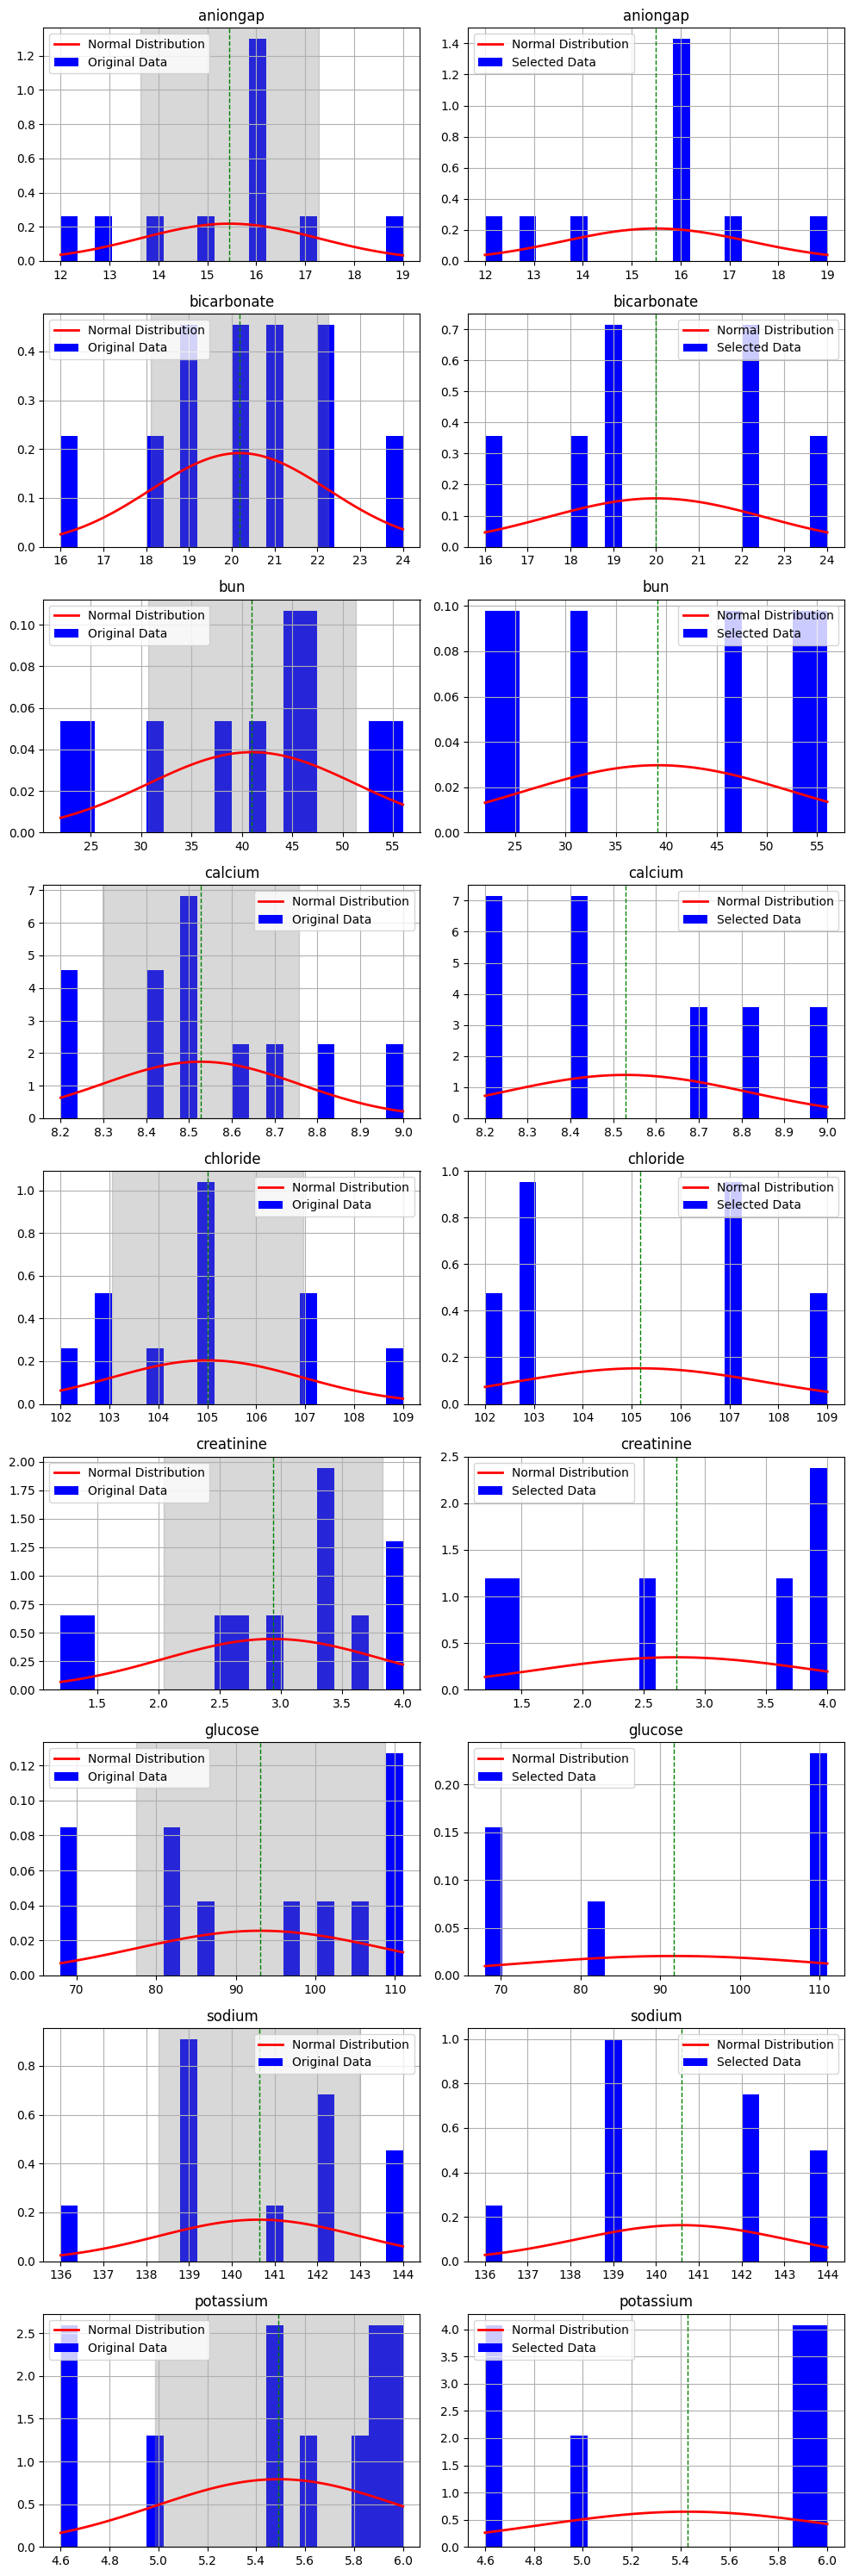

In [30]:


fig, axs = plt.subplots(nrows=9, ncols=2, figsize=(10, 30))

for i in range(9):
    
    ax = axs[i, 0]
    original_data = data.iloc[:, i]
    original_data = original_data[np.isfinite(original_data)]
    hist_original, bins_original = np.histogram(original_data, bins=20, density=True)
    bin_centers_original = (bins_original[1:] + bins_original[:-1]) / 2
    mu, std = norm.fit(original_data)
    ax.bar(bin_centers_original, hist_original, width=(bins_original[1] - bins_original[0]), color='blue', label='Original Data')
    x = np.linspace(min(original_data), max(original_data), 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
    ax.axvline(mu, color='green', linestyle='--', linewidth=1)
    shade_start = mu - std
    shade_end = mu + std
    ax.axvspan(shade_start, shade_end, alpha=0.3, color='grey')
    ax.set_title(name[i])
    ax.legend()
    ax.grid(True)
    
    
    ax = axs[i, 1]
    Q1 = np.percentile(original_data, 25)
    Q3 = np.percentile(original_data, 75)
    selected_data = original_data[(original_data <= Q1) | (original_data >= Q3)]
    hist_selected, bins_selected = np.histogram(selected_data, bins=20, density=True)
    bin_centers_selected = (bins_selected[1:] + bins_selected[:-1]) / 2
    mu, std = norm.fit(selected_data)
    ax.bar(bin_centers_selected, hist_selected, width=(bins_original[1] - bins_original[0]), color='blue', label='Selected Data')
    x = np.linspace(min(selected_data), max(selected_data), 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
    ax.axvline(mu, color='green', linestyle='--', linewidth=1)
    ax.set_title(name[i])
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [33]:
df_filtered = dynamic_train[dynamic_train['time_diff'] <= 24]
df_filtered_withouttime=df_filtered.drop(['charttime','start_time','time_diff'], axis=1)

baseline = df_filtered_withouttime.groupby('id').mean()
baseline_reset = baseline.reset_index(drop=False)

In [34]:
from scipy.stats import norm

def calculate_quantiles_features(df, features):
    results = []
    for patient_id, group in df.groupby('id'):
        patient_features = {'id': patient_id}
        for feature in features:
            values = group[feature].dropna()
            mean = values.mean()
            std = values.std()
            
            
            normalized_values = (values - mean) / std
            
            
            low_threshold = norm.ppf(0.25, loc=0, scale=1)
            high_threshold = norm.ppf(0.75, loc=0, scale=1)
            
            
            selected_values = values[(normalized_values <= low_threshold) | (normalized_values >= high_threshold)]
            
            
            modified_mean = selected_values.mean()
            modified_std = selected_values.std()
            
            
            q1_q4_percentage = len(selected_values) / len(values)
            
            
            patient_features[f'{feature}_modified_mean'] = modified_mean
            patient_features[f'{feature}_modified_std'] = modified_std
            patient_features[f'{feature}_q1_q4_percentage'] = q1_q4_percentage
            
        results.append(patient_features)
    
    return pd.DataFrame(results)

In [35]:
features = ['aniongap', 'bicarbonate', 'bun', 'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium']
quantiles_features_df = calculate_quantiles_features(dynamic_train, features)
quantiles_features_df =quantiles_features_df.drop('id',axis=1)
combined_df=pd.concat([baseline_reset,quantiles_features_df], axis=1)
combined_df=combined_df.fillna(0)

In [36]:
dynamic_val['charttime'] = pd.to_datetime(dynamic_val['charttime'], format='%m/%d/%y %H:%M')
dynamic_val['start_time'] = dynamic_val.groupby('id')['charttime'].transform('min')
dynamic_val['time_diff'] = (dynamic_val['charttime'] - dynamic_val['start_time']).dt.total_seconds() / 3600  
df_filtered2 = dynamic_val[dynamic_val['time_diff'] <= 24]
df_filtered_withouttime2=df_filtered2.drop(['charttime','start_time','time_diff'], axis=1)
baseline2 = df_filtered_withouttime2.groupby('id').mean()
baseline_reset2 = baseline2.reset_index(drop=False)
quantiles_features_df2 = calculate_quantiles_features(dynamic_val, features)
quantiles_features_df2 =quantiles_features_df2.drop('id',axis=1)
combined_df2=pd.concat([baseline_reset2,quantiles_features_df2], axis=1)
combined_df2=combined_df2.fillna(0)

In [37]:
dynamic_test['charttime'] = pd.to_datetime(dynamic_test['charttime'], format='%m/%d/%y %H:%M')
dynamic_test['start_time'] = dynamic_test.groupby('id')['charttime'].transform('min')
dynamic_test['time_diff'] = (dynamic_test['charttime'] - dynamic_test['start_time']).dt.total_seconds() / 3600  
df_filtered3 = dynamic_test[dynamic_test['time_diff'] <= 24]
df_filtered_withouttime3=df_filtered3.drop(['charttime','start_time','time_diff'], axis=1)
baseline3 = df_filtered_withouttime3.groupby('id').mean()
baseline_reset3 = baseline3.reset_index(drop=False)
quantiles_features_df3 = calculate_quantiles_features(dynamic_test, features)
quantiles_features_df3 =quantiles_features_df3.drop('id',axis=1)
combined_df3=pd.concat([baseline_reset3,quantiles_features_df3], axis=1)
combined_df3=combined_df3.fillna(0)


In [38]:
combined=combined_df.drop('id',axis=1)
scaler = StandardScaler()
combined_scaler= scaler.fit_transform(combined)
combined_scaled_df = pd.DataFrame(combined_scaler, columns=combined.columns, index=combined.index)
merged_two=pd.concat([combined_scaled_df,X_preprocessed_df], axis=1)

In [39]:
merged_two

,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,aniongap_modified_mean,...,remainder__atrial_fibrillation,remainder__malignant_cancer,remainder__chf,remainder__ckd,remainder__cld,remainder__copd,remainder__diabetes,remainder__hypertension,remainder__ihd,remainder__stroke
0,-0.106365,-0.119246,-0.056027,-1.701970,0.753852,0.370592,-0.356682,0.425433,0.837387,-0.009181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.106365,-0.505246,-0.056027,0.127731,-0.113651,-0.234523,0.566398,-0.120153,1.933277,-0.216459,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
2,0.007583,-1.084245,-0.608781,-0.192216,0.247809,-0.513807,0.301231,-0.120153,0.204207,-0.527377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.754786,0.266753,1.049482,0.087738,-1.101641,7.600950,-0.534294,-0.362636,3.467523,1.338130,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.676105,1.231752,-0.696719,0.607653,0.103225,-0.467260,-0.349177,0.425433,0.691269,-0.268279,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,0.691271,-0.505246,-0.395217,0.247712,0.103225,-0.327618,-1.234734,0.789157,0.983506,-0.216459,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6976,0.736850,0.691353,0.780642,-0.088233,-1.053447,0.556782,1.334881,-0.447505,1.041953,0.716294,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
6977,1.071098,-0.826912,0.258038,0.847614,-0.523306,0.029245,0.001043,-0.847601,0.496444,1.027212,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
6978,-0.904001,2.968750,-0.508280,0.607653,-1.487198,-0.467260,-1.009592,0.789157,-0.185443,-0.589561,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [40]:
static_feature2=static_val.drop(['id','hosp_admittime','hosp_dischtime','icu_intime','icu_outtime','los_icu','icu_death'], axis=1)
static_feature2.reset_index(drop=True)
static_feature2['race'] =static_feature2['race'].apply(map_race)
static_feature2['first_careunit'] =static_feature2['first_careunit'].apply(map_fc)
static_feature2['admission_type'] =static_feature2['admission_type'].apply(map_ad)
static_feature_withoutonehot2=static_feature2.drop(['los_icu_binned_1 to 2 days','los_icu_binned_2 to 4 days','los_icu_binned_4+ days'],axis=1)
transformed_data2 = column_transformer.fit_transform(static_feature_withoutonehot2)
feature_names_transformed2 = column_transformer.get_feature_names_out()
X_preprocessed_df2 = pd.DataFrame(transformed_data2 , columns=feature_names_transformed2)
combined2=combined_df2.drop('id',axis=1)
combined_scaler2= scaler.fit_transform(combined2)
combined_scaled_df2= pd.DataFrame(combined_scaler2, columns=combined2.columns, index=combined2.index)
merged_two2=pd.concat([combined_scaled_df2,X_preprocessed_df2], axis=1)

In [41]:
merged_two2

,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,aniongap_modified_mean,...,remainder__atrial_fibrillation,remainder__malignant_cancer,remainder__chf,remainder__ckd,remainder__cld,remainder__copd,remainder__diabetes,remainder__hypertension,remainder__ihd,remainder__stroke
0,-1.247354,0.427278,-0.433443,0.732474,-0.593061,-0.605776,-0.404335,-0.760426,0.972664,-1.139659,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,1.002368,-0.250959,-0.472810,0.440574,-0.593061,-0.538676,0.051044,-0.491882,0.972664,0.814117,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.414817,-0.800008,-0.676206,0.849234,-0.833143,-0.300098,1.703347,-1.028969,1.655052,1.019778,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-1.434831,0.621059,-0.991141,-0.707566,0.367265,-0.583409,-0.172913,0.462939,0.728955,-1.345319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.102479,0.088159,0.285004,-0.318366,-0.737110,-0.259093,-0.852249,-1.118484,1.155447,0.094305,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,-0.234979,0.039714,-0.807429,2.133593,1.279575,-0.583409,0.409374,1.119378,0.241535,-0.214186,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1936,-1.359840,1.977533,-0.807429,1.549793,0.271233,-0.404476,-0.695479,0.761320,0.533987,-0.831168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1937,-0.909896,0.814841,-1.161731,0.732474,-1.313306,-0.628142,-1.009018,-1.745085,-0.050916,-0.111356,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
1938,-0.010007,-0.477038,1.305264,0.615714,0.511314,0.415634,-0.481476,0.104881,-0.635820,-0.111356,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [42]:
static_feature3=static_test.drop(['id','hosp_admittime','hosp_dischtime','icu_intime','icu_outtime','los_icu','icu_death'], axis=1)
static_feature3.reset_index(drop=True)
static_feature3['race'] =static_feature3['race'].apply(map_race)
static_feature3['first_careunit'] =static_feature3['first_careunit'].apply(map_fc)
static_feature3['admission_type'] =static_feature3['admission_type'].apply(map_ad)
static_feature_withoutonehot3=static_feature3.drop(['los_icu_binned_1 to 2 days','los_icu_binned_2 to 4 days','los_icu_binned_4+ days'],axis=1)
transformed_data3 = column_transformer.fit_transform(static_feature_withoutonehot3)
feature_names_transformed3 = column_transformer.get_feature_names_out()
X_preprocessed_df3 = pd.DataFrame(transformed_data3 , columns=feature_names_transformed3)
combined3=combined_df3.drop('id',axis=1)
combined_scaler3= scaler.fit_transform(combined3)
combined_scaled_df3= pd.DataFrame(combined_scaler3, columns=combined3.columns, index=combined3.index)
merged_two3=pd.concat([combined_scaled_df3,X_preprocessed_df3], axis=1)



In [43]:
merged_two3

,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,aniongap_modified_mean,...,remainder__atrial_fibrillation,remainder__malignant_cancer,remainder__chf,remainder__ckd,remainder__cld,remainder__copd,remainder__diabetes,remainder__hypertension,remainder__ihd,remainder__stroke
0,-0.484521,0.248935,0.546162,2.788271,0.740844,-0.563929,-0.053941,0.565038,0.107393,-0.150321,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.658930,1.474426,0.435139,0.882535,-0.797381,1.562275,1.041803,0.655077,-0.366161,0.930293,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.114805,-1.099104,-0.658112,0.196470,1.106172,-0.430758,2.021012,1.069257,-0.710111,0.227894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.115391,0.657432,-0.955915,0.719187,0.356288,-0.684994,-0.698497,0.745116,1.353588,-0.474505,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.819670,0.810618,-0.064465,-1.431572,0.248131,2.527012,-0.578609,0.339941,-1.263422,0.101823,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,-0.957673,0.180853,-0.707746,-0.587604,0.308218,-0.548796,1.044381,0.384960,-0.640324,-0.906750,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
772,-1.509684,-0.023396,-0.851423,-1.168399,1.365748,-0.790926,-0.946006,0.324935,-0.490781,-1.663179,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
773,0.304066,-0.636141,-0.368146,0.319890,0.452427,0.086795,0.193568,-0.155273,2.101305,0.281925,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
774,0.126634,-0.516996,-0.534680,-0.805402,-1.157902,-0.401248,-0.481926,-1.820994,-1.487737,0.173864,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [44]:
static_train['tri'] = 0  
static_train.loc[static_train['los_icu_binned_1 to 2 days'] == 1, 'tri'] = 0  
static_train.loc[static_train['los_icu_binned_2 to 4 days'] == 1, 'tri'] = 1  
static_train.loc[static_train['los_icu_binned_4+ days'] == 1, 'tri'] = 2  

static_val['tri'] = 0  
static_val.loc[static_val['los_icu_binned_1 to 2 days'] == 1, 'tri'] = 0  
static_val.loc[static_val['los_icu_binned_2 to 4 days'] == 1, 'tri'] = 1  
static_val.loc[static_val['los_icu_binned_4+ days'] == 1, 'tri'] = 2  

static_test['tri'] = 0  
static_test.loc[static_test['los_icu_binned_1 to 2 days'] == 1, 'tri'] = 0  
static_test.loc[static_test['los_icu_binned_2 to 4 days'] == 1, 'tri'] = 1
static_test.loc[static_test['los_icu_binned_4+ days'] == 1, 'tri'] = 2



In [45]:
X_train=merged_two.fillna(0)
y_train_3bin=static_train['tri']
X_val=merged_two2.fillna(0)
y_val_3bin=static_val['tri']
X_test=merged_two3.fillna(0)
y_test_3bin=static_test['tri']


X_train.to_csv('output/X_train_3.csv')
y_train_3bin.to_csv('output/y_train_3.csv')
X_val.to_csv('output/X_val_3.csv')
y_val_3bin.to_csv('output/y_val_3.csv')
X_test.to_csv('output/X_test_3.csv')
y_test_3bin.to_csv('output/y_test_3.csv')